# 0.0 Imports

In [2]:
import math
import numpy as np
import seaborn as sns
import inflection
import pandas as pd


from PIL import Image
from tabulate import tabulate
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.preprocessing import LabelEncoder
from pycorrcat.pycorrcat import plot_corr, corr_matrix
from sklearn.preprocessing import RobustScaler, MinMaxScaler

## 0.1 Help Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [5]:
df_sales = pd.read_csv('/home/guilherme/Documentos/repos/datascienceemproducao/data/train.csv',low_memory=False)

df_store = pd.read_csv('/home/guilherme/Documentos/repos/datascienceemproducao/data/store.csv',low_memory=False)

#merge
df_raw = pd.merge(df_sales,df_store,how= 'left', on='Store')

# 1.0 Descrition Data

In [6]:
df1 = df_raw.copy(deep=True)

## 1.1  Rename Columns

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

#function to convent columns format snackcase
snackcase= lambda x: inflection.underscore( x )


cols_new= list( map( snackcase, cols_old ))

#rename columns 

df1.columns = cols_new



## 1.2 Data Dimensions

In [9]:
print('The number of    Rows: {}'.format(df1.shape[0]))
print('The number of Columns: {}'.format(df1.shape[1]))

The number of    Rows: 1017209
The number of Columns: 18


## 1.3 Data Types

In [10]:
# convent the colum data to datetime64
df1['date'] = df1['date'].astype('datetime64[ns]')

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.4.1 Check NA %

In [12]:
df1.isna().sum() / df1.shape[0] * 100

store                            0.000000
day_of_week                      0.000000
date                             0.000000
sales                            0.000000
customers                        0.000000
open                             0.000000
promo                            0.000000
state_holiday                    0.000000
school_holiday                   0.000000
store_type                       0.000000
assortment                       0.000000
competition_distance             0.259730
competition_open_since_month    31.787764
competition_open_since_year     31.787764
promo2                           0.000000
promo2_since_week               49.943620
promo2_since_year               49.943620
promo_interval                  49.943620
dtype: float64

## 1.5 FillOut NA

In [13]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x )



df1['competition_open_since_month']= df1.apply(lambda x: x['date'].month if 
                                               math.isnan(x['competition_open_since_month']) 
                                               else x['competition_open_since_month'], axis=1)



df1['competition_open_since_year']= df1.apply(lambda x: x['date'].year if
                                              math.isnan(x['competition_open_since_year']) 
                                              else x['competition_open_since_year'],axis=1)


df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                     else x['promo2_since_week'],axis=1)

df1['promo2_since_year']= df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                     else x['promo2_since_year'],axis=1)


#dict of year to month
month_map = {1: 'Jan',2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',
             6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov' ,12: 'Dec' }


#substituindo NA por 0
df1['promo_interval'].fillna(0,inplace=True)

#extract month data 
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x:0 if x['promo_interval']==0 
                                                            else 1 if x['month_map'] in x['promo_interval'].split( ',' ) 
                                                            else 0,axis=1)


In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [15]:


df1['promo2_since_week']  = df1['promo2_since_week'] .astype(int)

df1['promo2_since_year']  = df1['promo2_since_year'] .astype(int)

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

df1['competition_open_since_year'] =  df1['competition_open_since_year'].astype(int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descrptive Statistics

In [16]:
num_attributes = df1.select_dtypes( include = ['int64','float64'] )

cat_attributes = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]'] )

## 1.7.1 Numeric Attributes

In [17]:
#tendecy Central

#mean and median 

t1 = pd.DataFrame(num_attributes.apply(lambda x: np.mean( x ) ) ).T
t2 = pd.DataFrame(num_attributes.apply(lambda x: np.median( x ) ) ).T

# min - max - std - range - skew - kurtose

#min 
d1 = pd.DataFrame(num_attributes.apply(lambda x: np.min(x) ) ).T

#max
d2 = pd.DataFrame(num_attributes.apply(lambda x: np.max(x) ) ).T

#range

d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() ) ).T

#std 

d4 = pd.DataFrame(num_attributes.apply(lambda x: np.std(x) ) ).T

#skew

d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() ) ).T

#kurtosis
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() ) ).T

#concat metrics
m1 = pd.concat([t1,t2,d1,d2,d3,d4,d5,d6]).T.reset_index()

#rename columns
m1.columns = ['attributes','mean','median','min','max','range','std','skew','kurtosis']
m1

,attributes,mean,median,min,max,range,std,skew,kurtosis
0,store,558.429727,558.0,1.0,1115.0,1114.0,321.908493,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.0,7.0,6.0,1.997390,0.001593,-1.246873
2,sales,5773.818972,5744.0,0.0,41551.0,41551.0,3849.924283,0.641460,1.778375
3,customers,633.145946,609.0,0.0,7388.0,7388.0,464.411506,1.598650,7.091773
4,open,0.830107,1.0,0.0,1.0,1.0,0.375539,-1.758045,1.090723
5,promo,0.381515,0.0,0.0,1.0,1.0,0.485758,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.0,1.0,1.0,0.383056,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,20.0,200000.0,199980.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,1.0,12.0,11.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,1900.0,2015.0,115.0,5.515591,-7.235657,124.071304


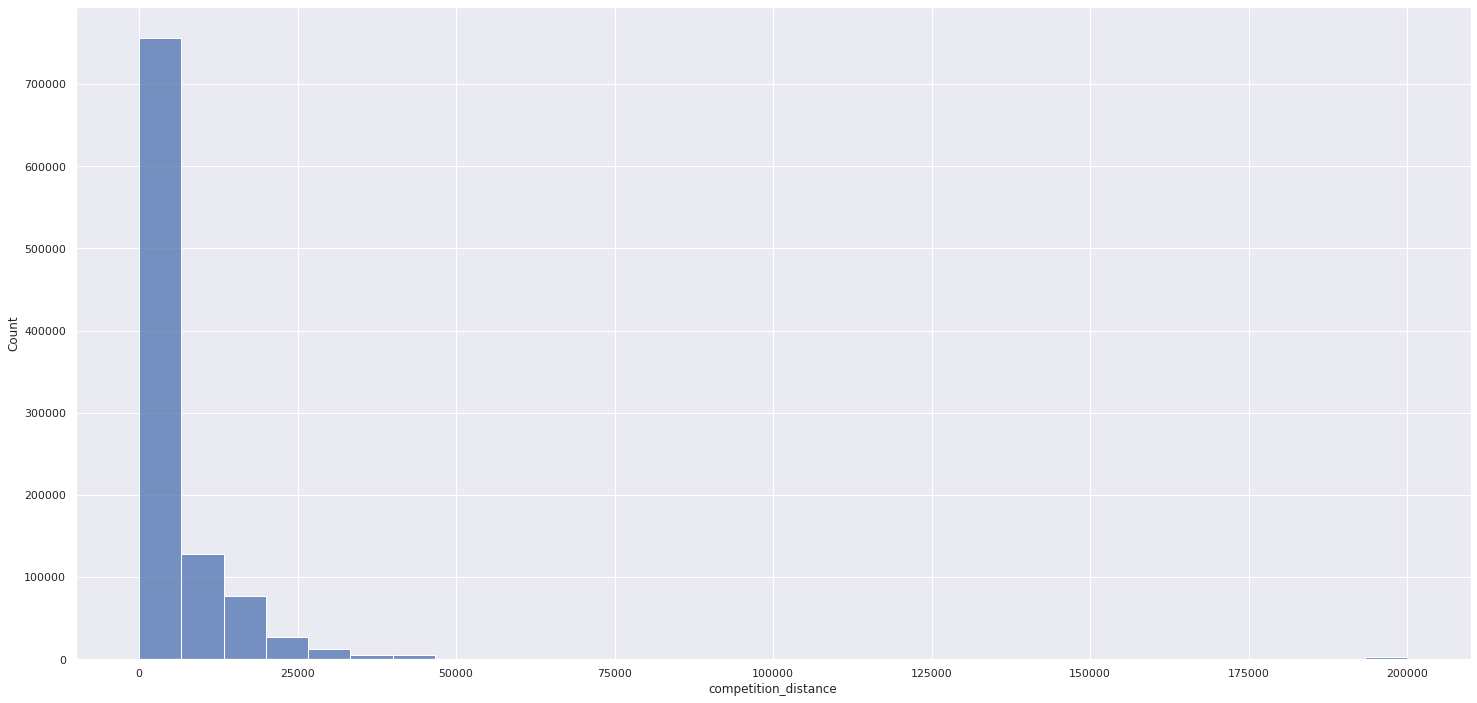

In [18]:
#sns.distplot(df1['competition_distance'],kde=False);
sns.histplot(df1['competition_distance'],bins=30);

## 1.7.2 Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

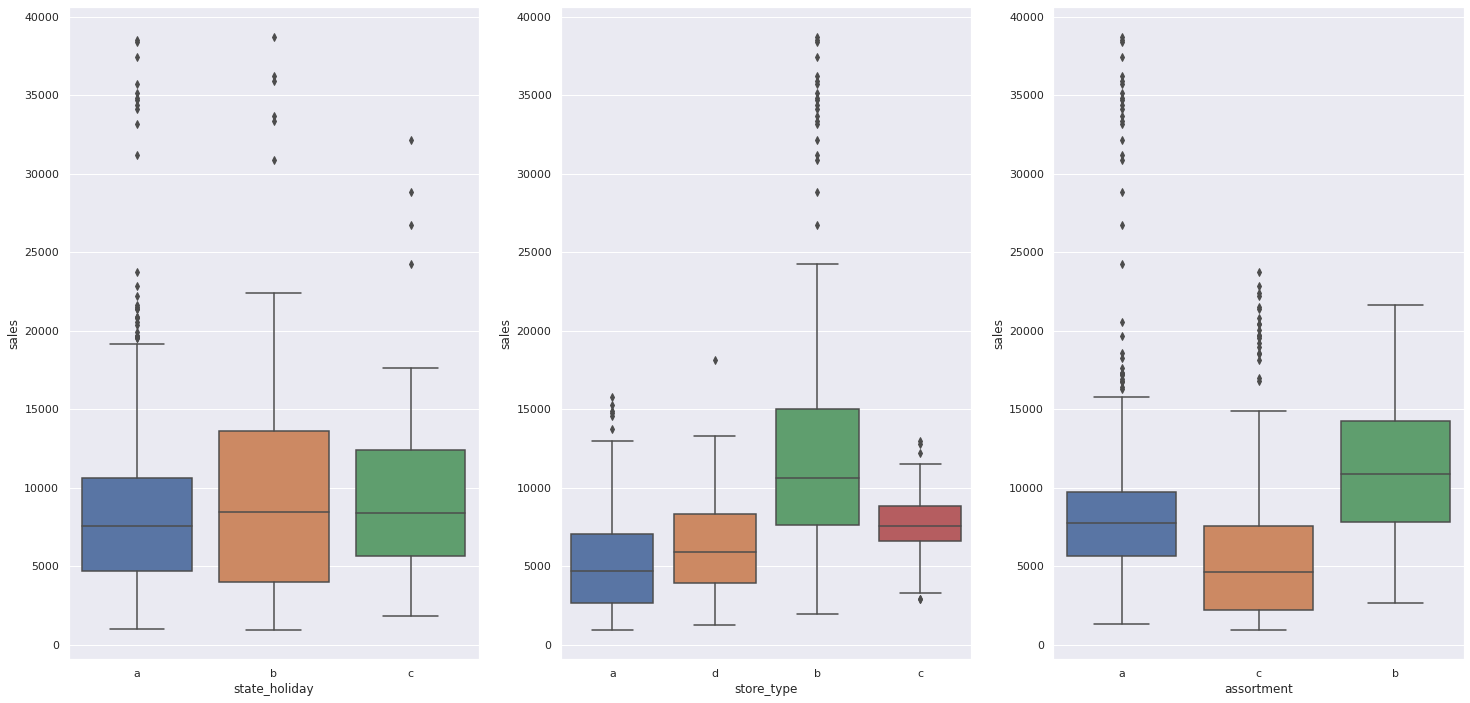

In [20]:
#filter the data
aux1 = df1[(df1['state_holiday']!= '0') & (df1['sales']> 0) ]

#state holiday
plt.subplot(1,3,1)
sns.boxplot(x= 'state_holiday', y='sales', data=aux1);

#store_type
plt.subplot(1,3,2)
sns.boxplot(x= 'store_type', y='sales', data=aux1);

#assortment
plt.subplot(1,3,3)
sns.boxplot(x= 'assortment', y='sales', data=aux1);

# 2.0 Feature Engineering

In [21]:
df2= df1.copy(deep=True)

## 2.1 Mind Map Hpyothesis

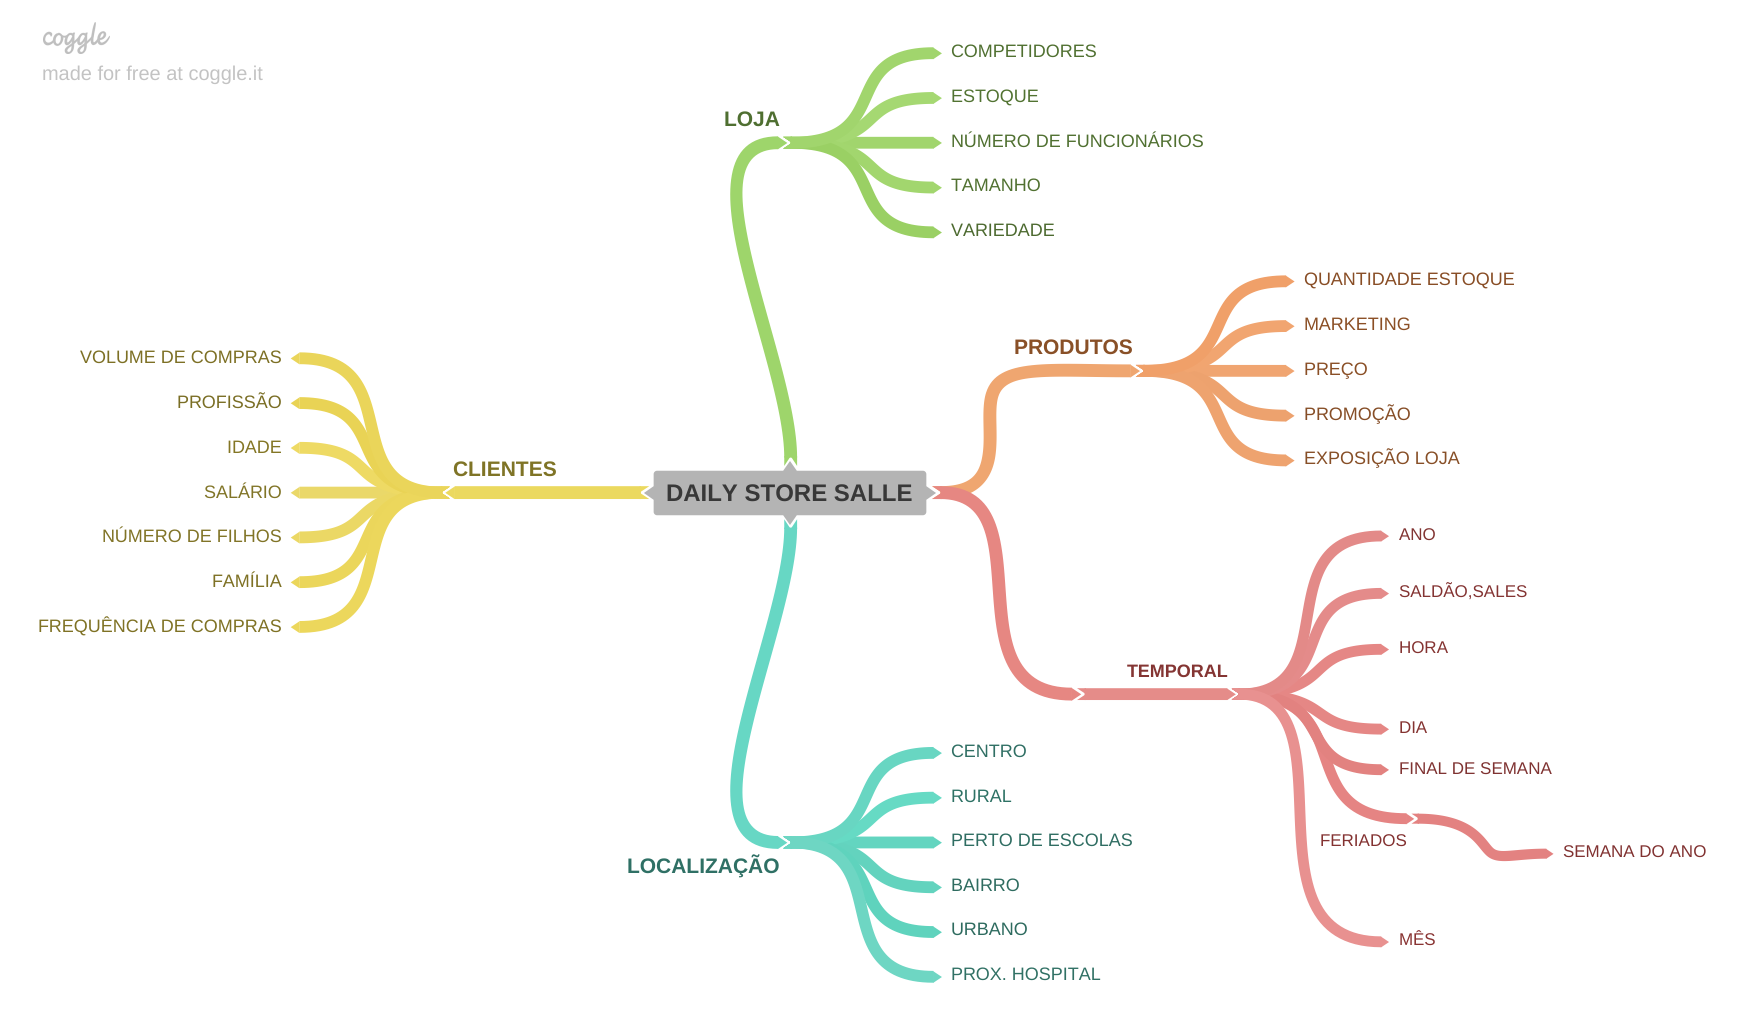

## 2.2 - List Hpyothesis

## 2.2.1 Store Hpyothesis 

**1** . Lojas com número maior de fúncionários deveriam vender mais.

**2**. Lojas com maior variedades de produtos deveriam vender mais.

**3**. Lojas com maior porte deveriam vender mais.

**4**. Lojas com maior capacidade de estoque deveriam vender mais.

**5**. Lojas com competidores mais próximo deveriam venderiam mais.

**6**. Lojas com competidores à mais tempo deveriam vender mais.

## 2.2.2 Product Hpyothesis

**1**. Lojas que fazem mais ação de marketing deveriam vender mais.

**2**. Lojas com mais exposição dos seus produtos deveriam vender mais.

**3**. Lojas que ativam promoções por mais tempo deveriam vender mais.

**4**. Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5**. Lojas com mais promoções deveriam vender mais.

**6**. Lojas com mais promoções consecutivas deveriam vender mais.

**7**. Lojas que tem preços mais baixos deveriam vender mais.

**8**. Lojas com mais produtos em estoque deveriam vender mais.

## 2.2.3 Temporal Hpyothesis

**1**. Lojas abertas no feriaodo de Natal deveriam vender mais.

**2**. Lojas deveriam vender mais ao longo dos anos.

**3**. Lojas deveriam vender mais depois do dia 10 de cada mês.

**4**. Lojas deveriam vender menos aos finais de semana.

**5**. Lojas deveriam vender mais no segundo semestre do ano.

**6**. Lojas deveriam vender menos nos feriaods escolares.

## 2.3 List Final Hpyothesis

**1**. Lojas com maior sortimentos deveriam vender mais.

**2**. Lojas com competidores mais próximos deveriam vender menos.

**3**. Lojas com competidores à mais tempo deveriam vendem mais.

**4**. Lojas com promoções ativas por mais tempo deveriam vender mais.

**5**. Lojas com mais dias de promoção deveriam vender mais.

**7**. Lojas com mais promoções consecutivas deveriam vender mais.

**8**. Lojas abertas durante o feriado de Natal deveriam vender mais.

**9**. Lojas deveriam vender mais ao longo dos anos.

**10**. Lojas deveriam vender mais no segundo semestre do ano.

**11**. Lojas deveriam vender mais depois do dia 10 de cada mês.

**12**. Lojas deveriam vender menos aos finais de semana.

**13**. Lojas deveriam vender menos durante os feriados escolares.



## 2.4 Feature Engineering

In [22]:
df2['year']= df2['date'].dt.year

df2['month'] = df2['date'].dt.month

df2['day'] = df2['date'].dt.day

df2['week_of_year'] = df2['date'].dt.isocalendar().week

df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                               month=x['competition_open_since_month'],
                                                               day=1),axis=1)

df2['compettion_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply(lambda x: x.days).astype(int)

#join the columns promo2
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

# convent promo time week to datetime
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1','%Y-%W-%w') - datetime.timedelta(days=7) )


#calcule between start promo and continuation 
df2['promo_time_week'] = (( df2['date'] - df2['promo_since'] ) /7 ).apply(lambda x: x.days).astype(int)

# renome names assortment 
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x== 'a' else 'extra' if x =='b'else 'extended')

#rename state holiday

df2['state_holiday']= df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' 
                                                 else 'easter_holiday' if x=='b' 
                                                 else 'christmas' if x=='c'
                                                 else 'regular_day')

# 3.0 Variable Filtering

In [23]:
df3 = df2.copy(deep=True)

## 3.1 Filtering the data

In [24]:
#filtereing the rows open and sales of dataset

df3= df3.loc[(df3['open'] > 0) & (df3['sales'] > 0) ] 

## 3.2 Select the columns

In [25]:
cols_drop= ['customers','open','promo_interval','month_map']

df3 = df3.drop( cols_drop,axis=1 )

# 4 EDA

In [26]:
df4 = df3.copy(deep=True)

## 4 .1  Analise Univariada

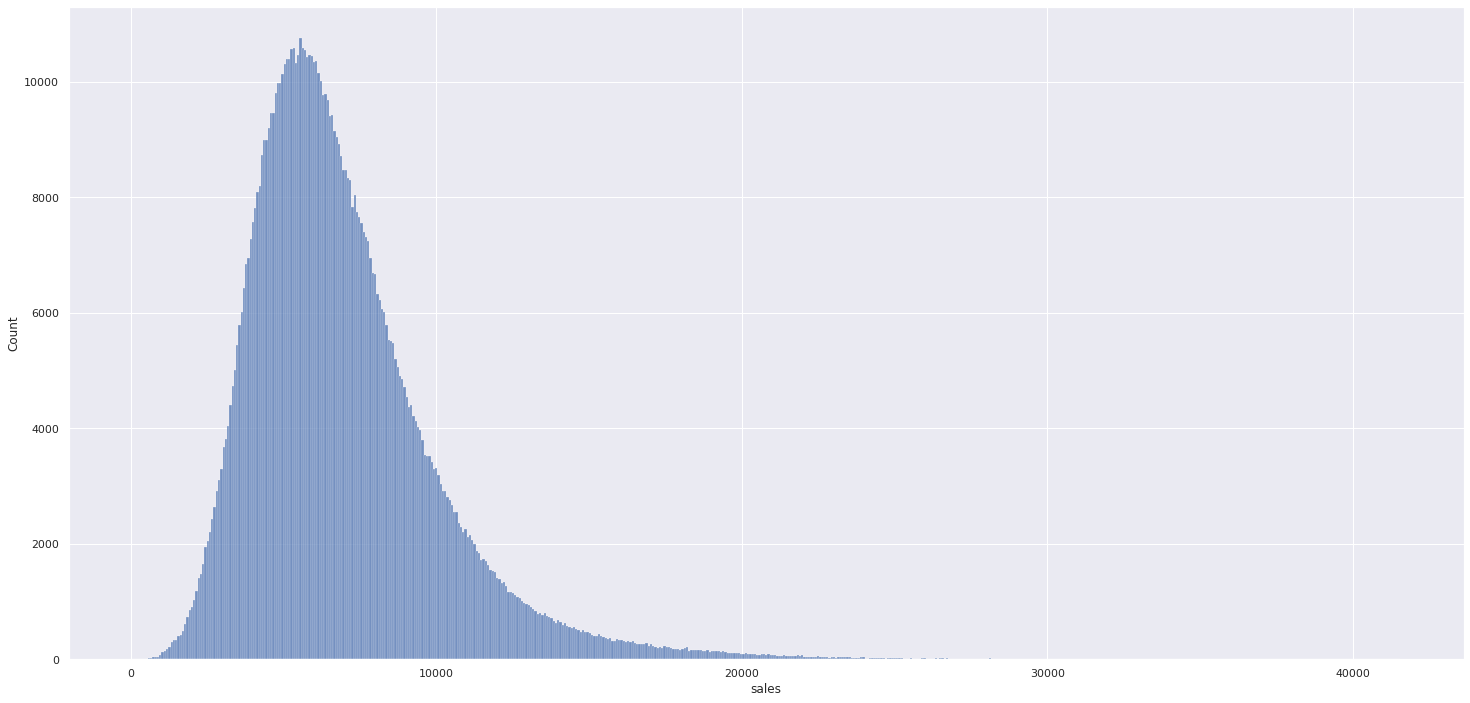

In [27]:
sns.histplot( df4['sales'] );

## Numeric Variable

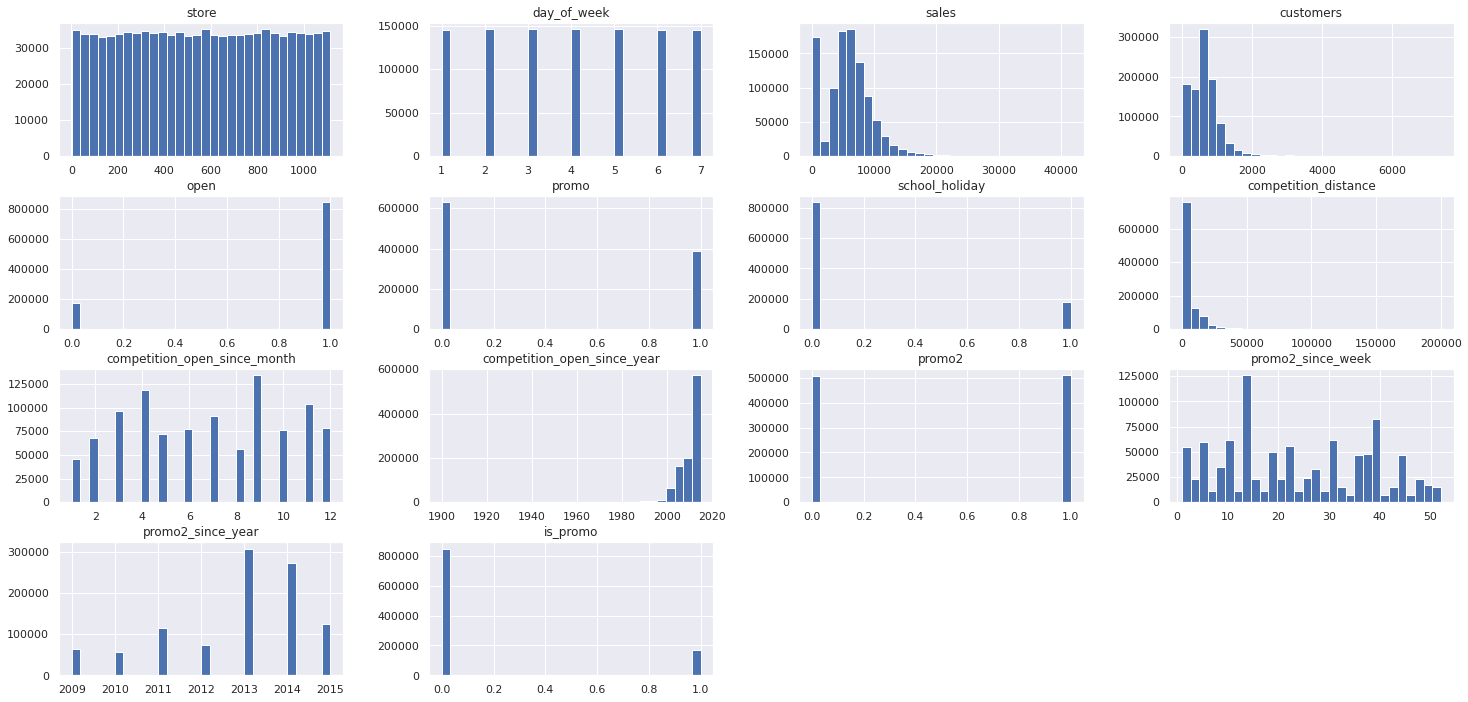

In [28]:
num_attributes.hist(bins=30);

* Plot Store: Não há diferença significativa de vendas entre lojas;
* Plot day of week : Não há nenhum dia especifico da semana que há um aumento nas vendas;
* Plot Sales: 
* Plot Customers: Neste demostra que quando há uma concetração maior de clientes nas lojas gerlamene há um aumento nas vendas;
* Plot open : Como esperados lojas abertas tem vendas maiores;
* Plot Promo : Neste plot há uma certa supresa. Há uma probabilidade maior de não ter vendas maiores quando há promoções;
* Plot School Holiday: Como já é esperado as vendas maiores são em dias regulares;
* Plot Competition Distance: Plot aponta que as vendas são maiores quando há competidores mais próximos. 
* Plot Competition Open Since Month: Neste plot é possível observar que os mês com maior pico de vendas é no mês 9;
* Plor Competition Open Since Year: No plot no período vendas anual é é possível observar que após ano de 2010 houve aumento nas vendas;
* Plot Promo2: Neste gráfico é possível analisar algo interessante. Que a continuação da promoção não afeta as chances de vender mais;
* Plot Promo Since Week: Neste plot semanal é observado que há um pico de vendas entre a semana 10 à 20. É necessário uma analisa mais aprofundada para saber o motivo de geralmente as promoções funcionarem melhor neste período. 
* Promo2 Since Year: Neste plot é possível concluir que o ano de 2013 e 2014 tiveram vendas bem significativas em relação aos demais anos;
* Is Promo: Neste gráfico é demostrado algo geralmente incomum na área de vendas. As promoções tem efeito menor nas vendas. 

## Categoric Variable

In [29]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [30]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

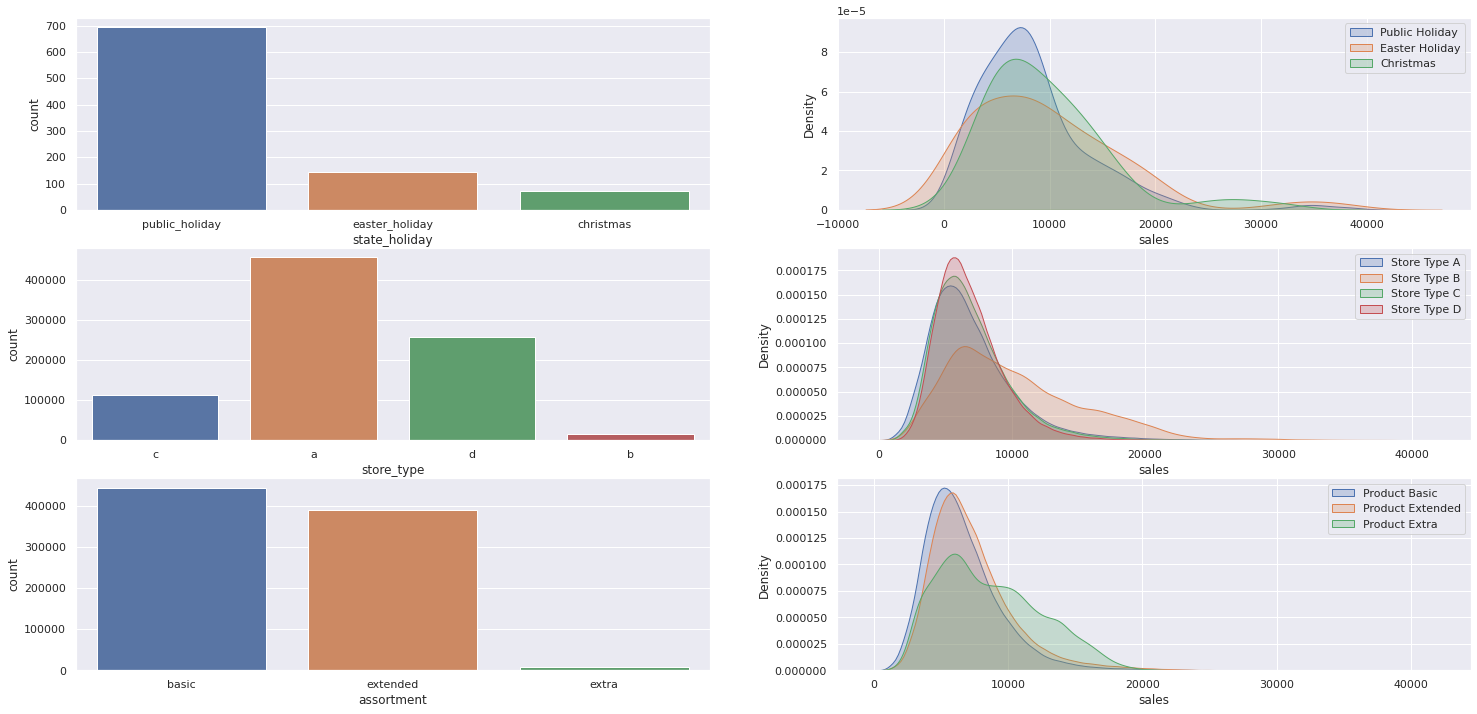

In [31]:
#comparando as vendas dos feriados
plt.subplot(3,2,1)

aux = df4[df4['state_holiday']!= 'regular_day']

sns.countplot(x='state_holiday', data = aux);

plt.subplot(3,2,2)
sns.kdeplot(df4.loc[df4['state_holiday']=='public_holiday']['sales'],label= 'Public Holiday',shade=True);
sns.kdeplot(df4.loc[df4['state_holiday']=='easter_holiday']['sales'],label= 'Easter Holiday',shade=True);
sns.kdeplot(df4.loc[df4['state_holiday']=='christmas']['sales'],label= 'Christmas',shade=True);
plt.legend(loc='best');

#store type
plt.subplot(3,2,3)
sns.countplot(x='store_type',data= df4);

plt.subplot(3,2,4)
sns.kdeplot(df4.loc[df4['store_type'] == 'a']['sales'], label='Store Type A',shade=True);
sns.kdeplot(df4.loc[df4['store_type'] == 'b']['sales'], label='Store Type B',shade=True);
sns.kdeplot(df4.loc[df4['store_type'] == 'c']['sales'], label='Store Type C',shade=True);
sns.kdeplot(df4.loc[df4['store_type'] == 'd']['sales'], label='Store Type D',shade=True);
plt.legend(loc='best');
#assortment

plt.subplot(3,2,5)
sns.countplot(x='assortment',data=df4);

plt.subplot(3,2,6)
sns.kdeplot(df4.loc[df4['assortment'] == 'basic']['sales'], label='Product Basic',shade=True);
sns.kdeplot(df4.loc[df4['assortment'] == 'extended']['sales'], label='Product Extended',shade=True);
sns.kdeplot(df4.loc[df4['assortment'] == 'extra']['sales'], label='Product Extra',shade=True);
plt.legend(loc='best');

## 4.2 Analise Bivariada

## H1 . Lojas com número maior de fúncionários deveriam vender mais.

## H2. Lojas com maior variedades de produtos deveriam vender mais.

### Falsa - Lojas com MAIS sortimentos vendem MENOS

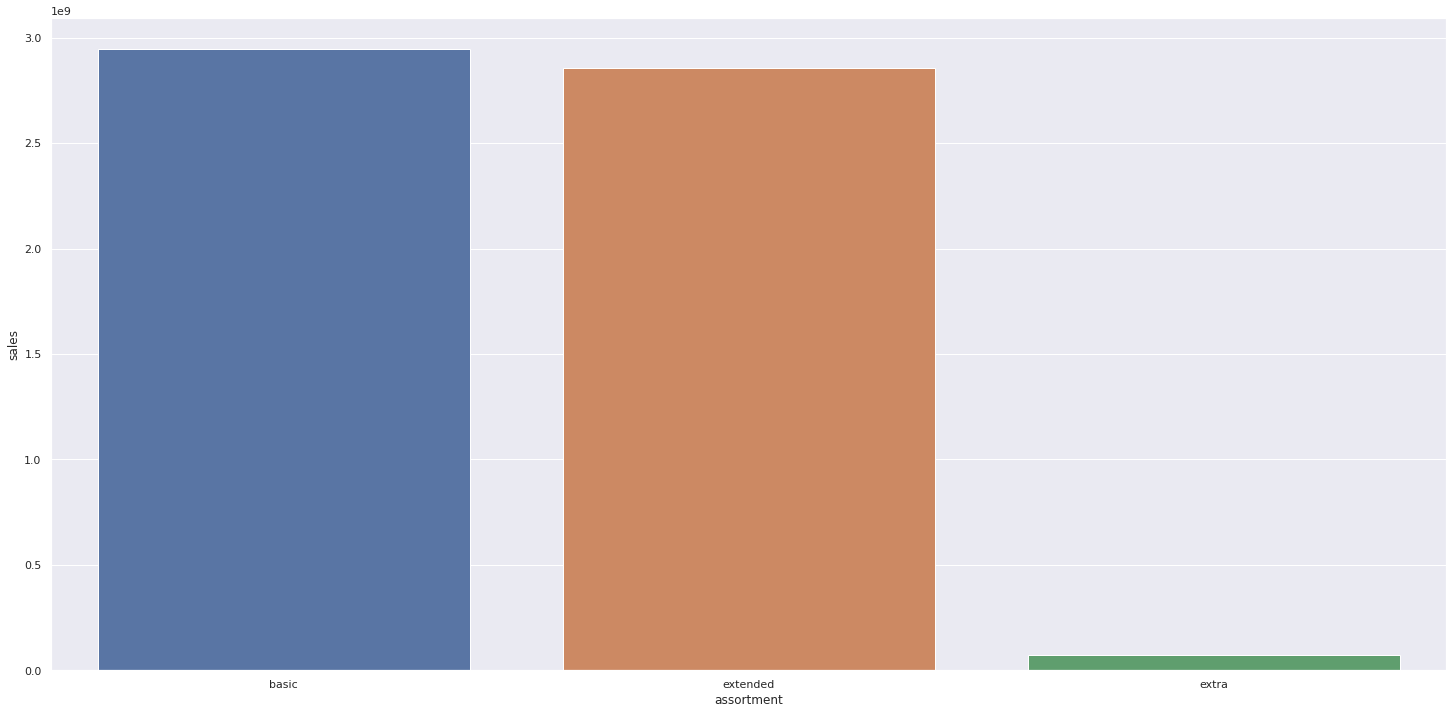

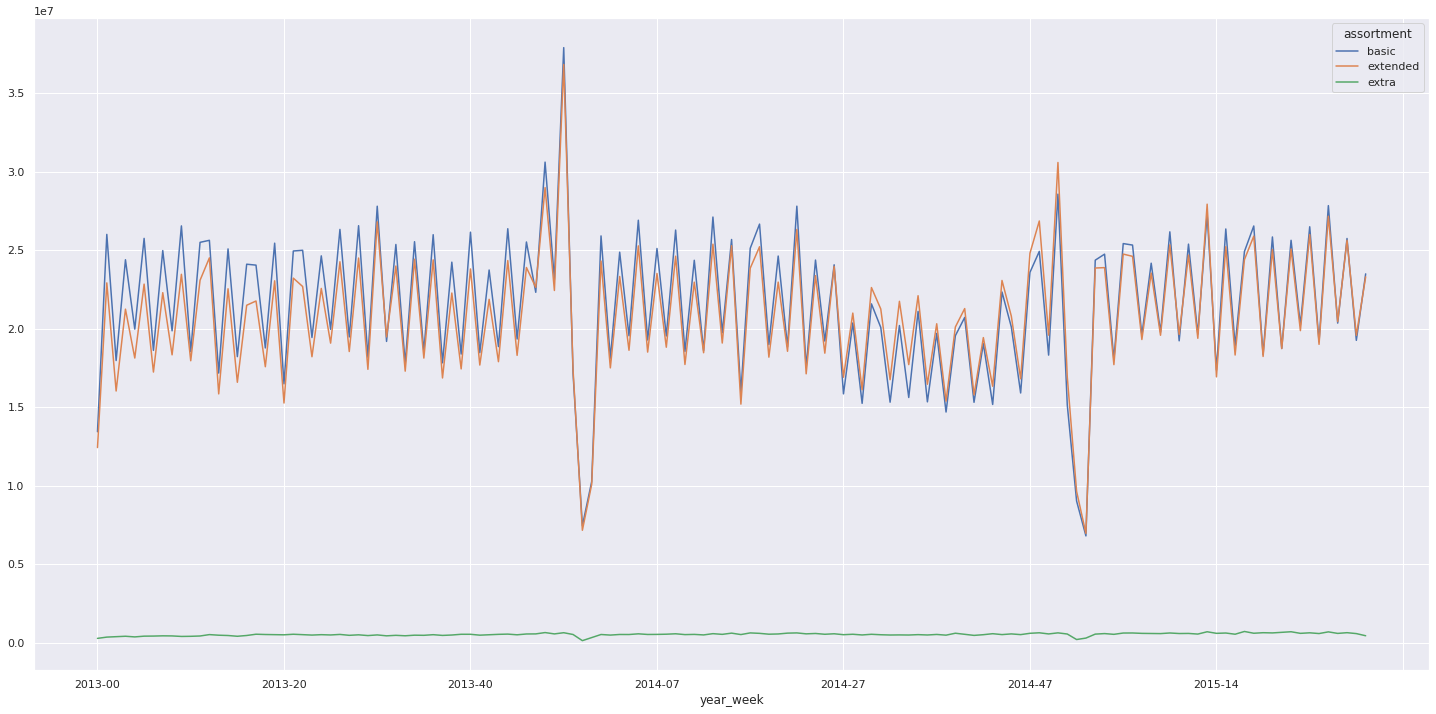

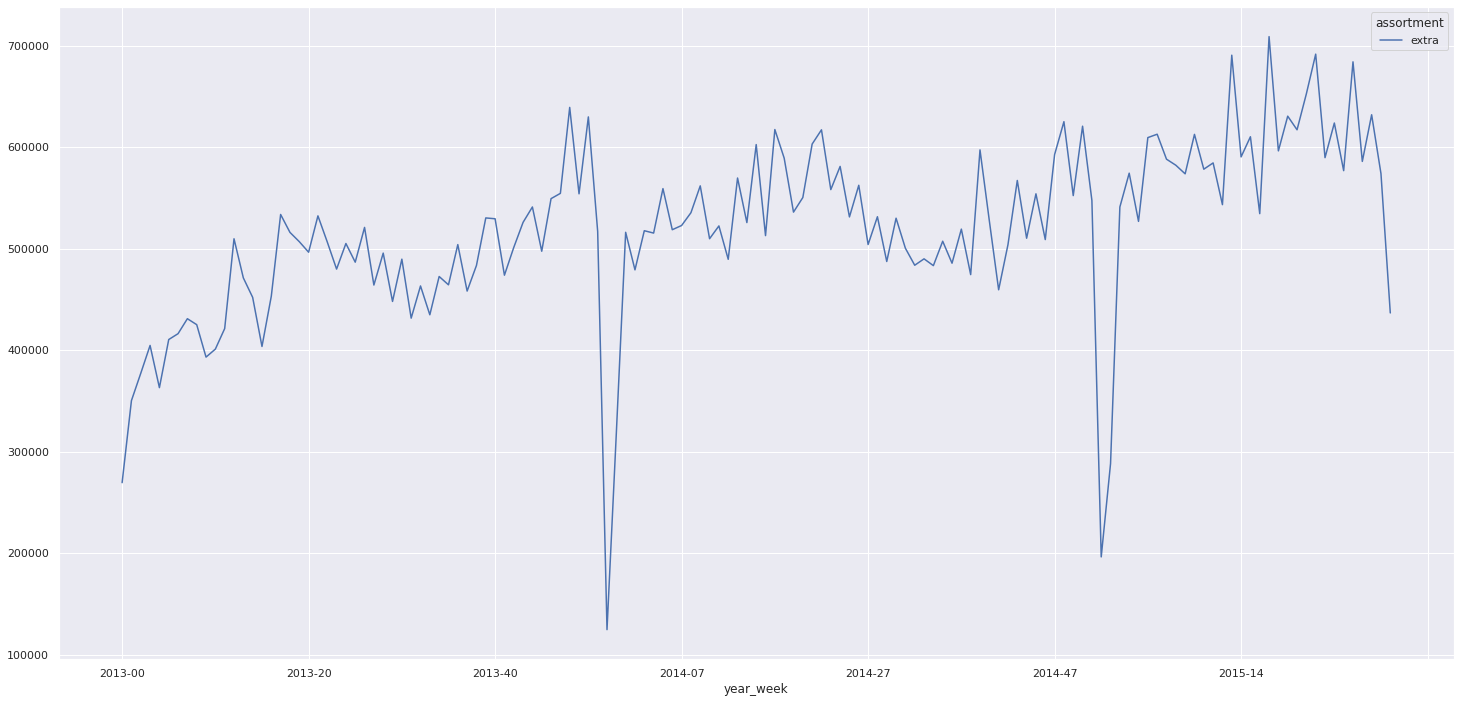

In [32]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()

sns.barplot(x='assortment',y='sales', data = aux1);


aux2 = df4[['assortment','sales','year_week']].groupby(['assortment','year_week']).sum().reset_index()

aux2.pivot(index='year_week',columns='assortment',values='sales').plot();


aux3 = aux2.loc[aux2['assortment']=='extra']
aux3.pivot(index= 'year_week', columns='assortment', values='sales').plot();

## H3 - Lojas com competidores mais próximo deveriam venderiam menos.

### Falso: Lojas vendem mais com competidores mais próximo.

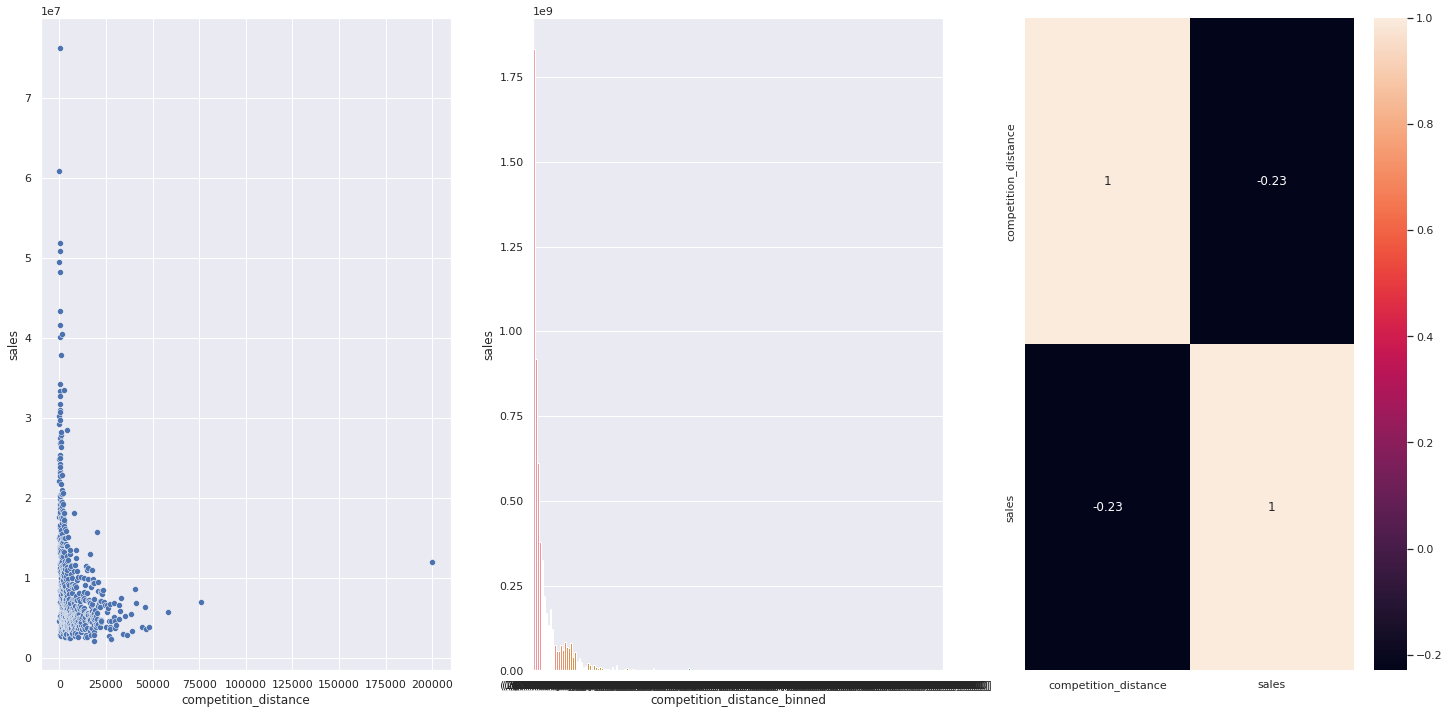

In [33]:
plt.subplot(1,3,1)

aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

sns.scatterplot(x= 'competition_distance', y = 'sales', data = aux1)

plt.subplot(1,3,2)

#agrupando a disntancia em grupos
bins = list(np.arange(0,200000,1000))

#encaixando o grupos criados em uma nova coluna 
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x = 'competition_distance_binned', y= 'sales', data = aux2);

plt.subplot(1,3,3)
#heatmap
sns.heatmap(aux1.corr(method='pearson'),annot=True);



## H4 - Lojas com competidores à mais tempo deveriam vender mais.

### Falso: Lojas compentidores à mais tempo vendem menos.

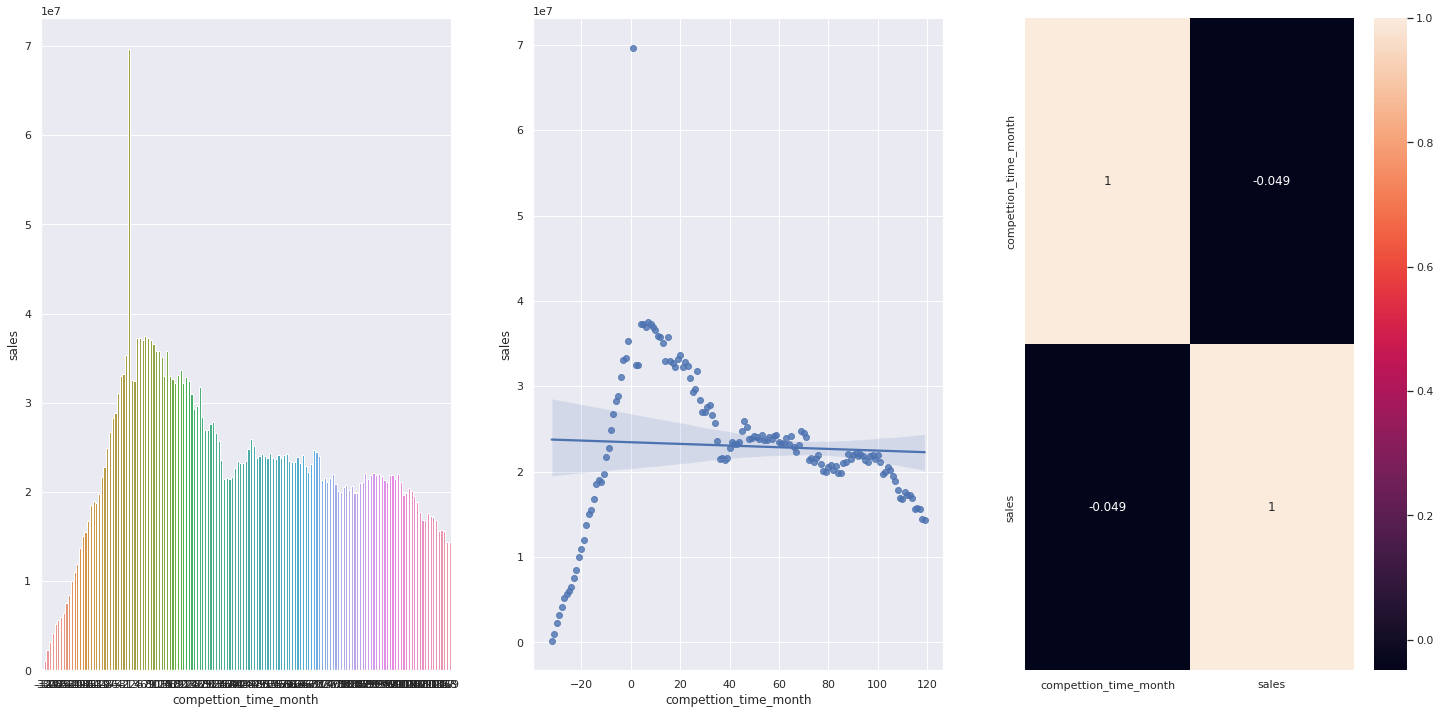

In [34]:
aux1 = df4[['compettion_time_month','sales']].groupby('compettion_time_month').sum().reset_index()

aux2 = aux1[(aux1['compettion_time_month'] < 120) & (aux1['compettion_time_month']!= 0)]

plt.subplot(1,3,1)
sns.barplot(x ='compettion_time_month', y = 'sales', data= aux2 );

plt.subplot(1,3,2)
sns.regplot(x = 'compettion_time_month', y = 'sales' , data= aux2);

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'), annot= True);

## H5 - Lojas que ativam promoções por mais tempo deveriam vender mais.

### Falso: Lojas que tem promoões por mais tempo vendem menos

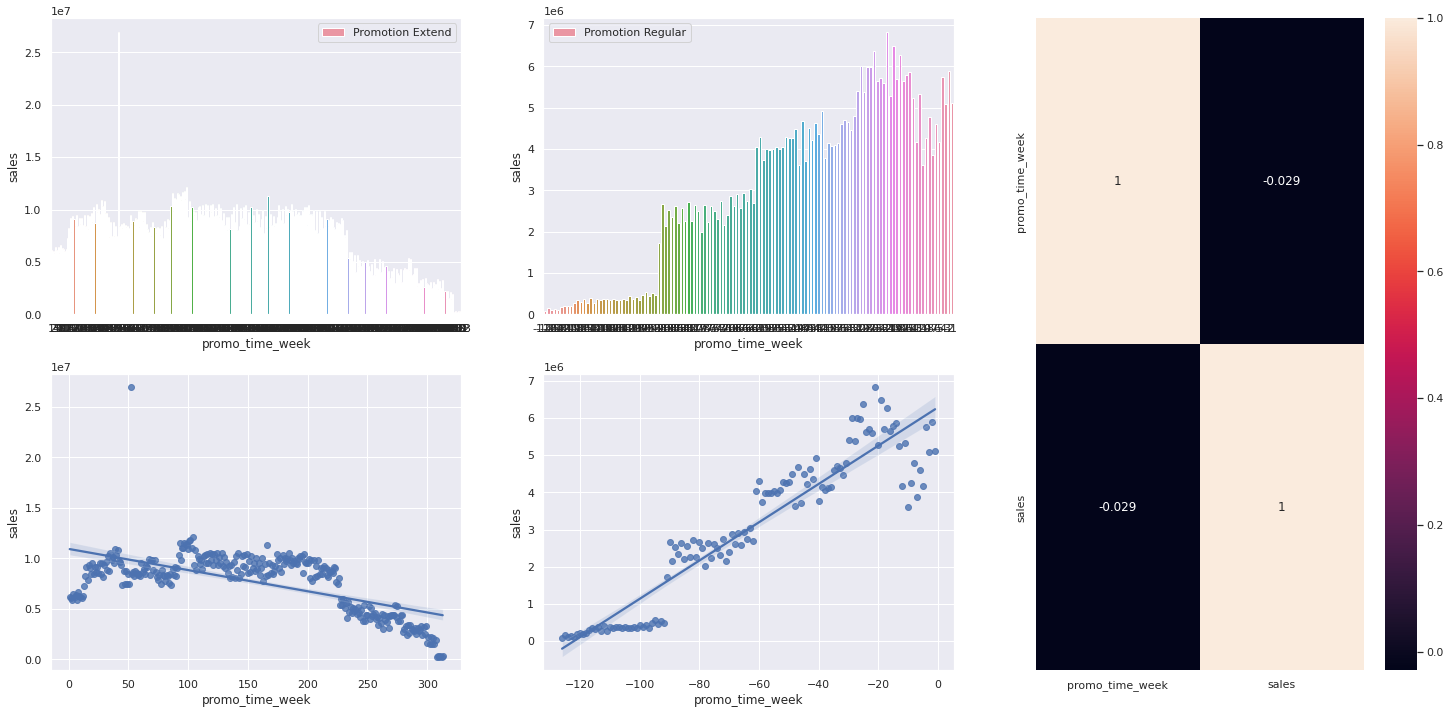

In [35]:
# ======= Promotion extend ========================= #

aux = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2 ,3)

aux1 = aux.loc[aux['promo_time_week']> 0]

plt.subplot( grid[0,0] )
sns.barplot(x= 'promo_time_week', y = 'sales', data=aux1, label= 'Promotion Extend');
plt.legend(loc='best');

plt.subplot( grid[1,0] )
sns.regplot(x = 'promo_time_week', y= 'sales', data=aux1);

plt.subplot(grid[0,1])


# ================== Promotion Regular =================

aux3 = aux.loc[aux['promo_time_week']< 0]

sns.barplot(x= 'promo_time_week', y = 'sales', data=aux3, label= 'Promotion Regular');
plt.legend(loc='best');

plt.subplot( grid[1,1] )
sns.regplot(x = 'promo_time_week', y= 'sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux.corr(method='pearson'), annot=True);

## H6- Lojas com mais promoções consecutivas deveriam vender mais.

### Falso - Lojas com mais promoções sucessivas não vendem mais.

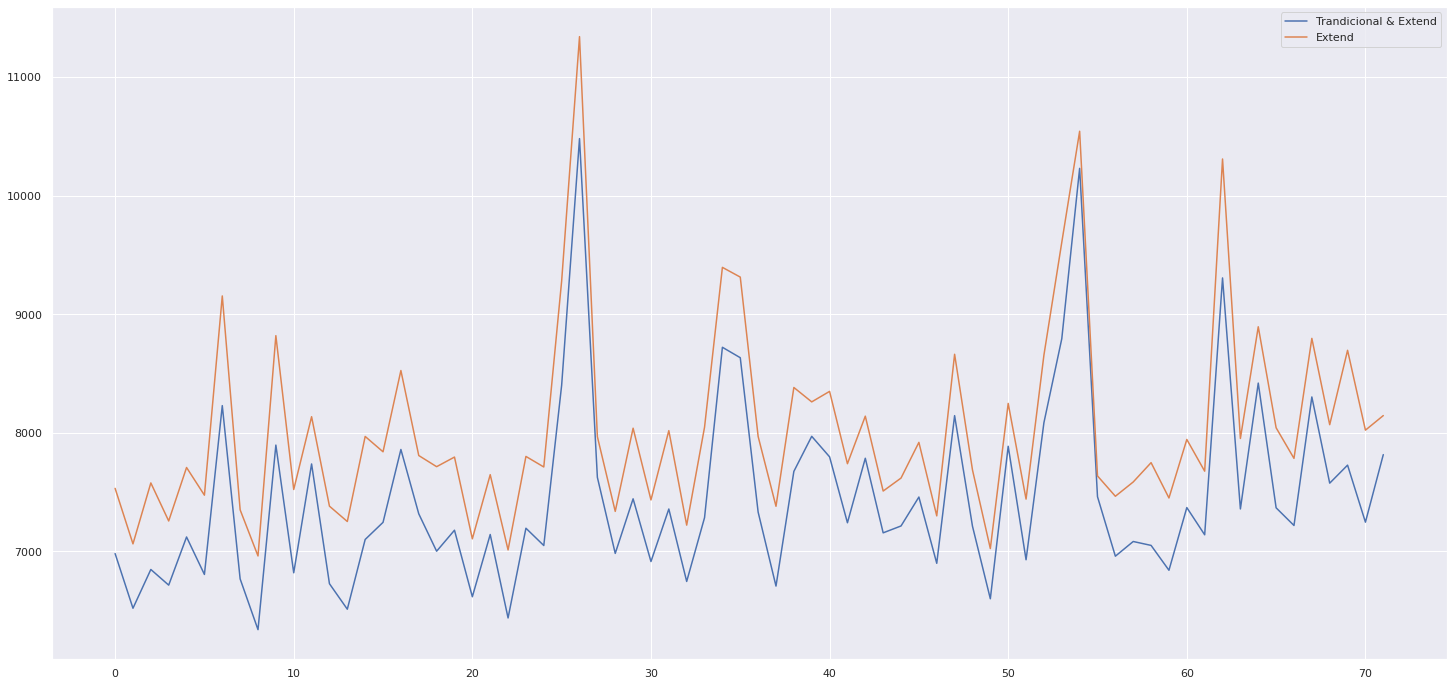

In [36]:
#select the store with regular promo and promo extend. 
aux1 = df4.loc[ (df4['promo']==1) & (df4['promo2']==1)][['sales','year_week']].groupby('year_week').median().reset_index()
plot1 = aux1.plot();
plot1

aux2 = df4.loc[ (df4['promo']==1) & (df4['promo2']==0)][['sales','year_week']].groupby('year_week').median().reset_index()
plot2 = aux2.plot(ax = plot1);

plot2;

plot1.legend(labels= ['Trandicional & Extend', 'Extend'] );

## H7 - Lojas abertas durante o feriado de Natal deveriam vender mais.

### Falso: Lojas abertas durante o feriado de Natal vendem menos.

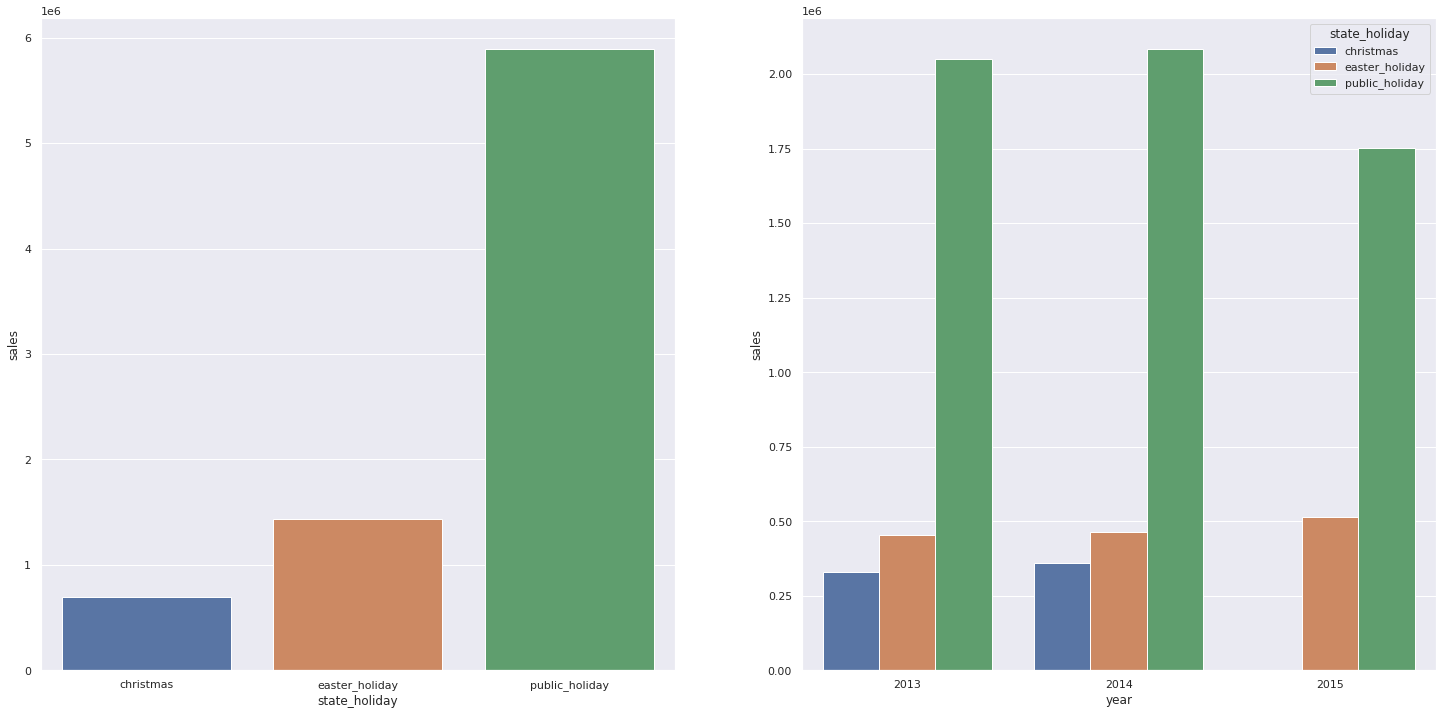

In [37]:
# ========= Comparative between the Holidays ====================#


aux = df4.loc[df4['state_holiday'] !='regular_day']

aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x ='state_holiday', y= 'sales', data = aux1);


# ========= Comparative holiday by year ==================#

aux2 = aux[['state_holiday','sales','year']].groupby(['state_holiday','year']).sum().reset_index()

plt.subplot(1,2,2)
sns.barplot(x ='year', y = 'sales', hue ='state_holiday', data= aux2);

## H8 - Lojas deveriam vender mais ao longo dos anos.

### Falso: Lojas vendem menos ao longo dos anos.

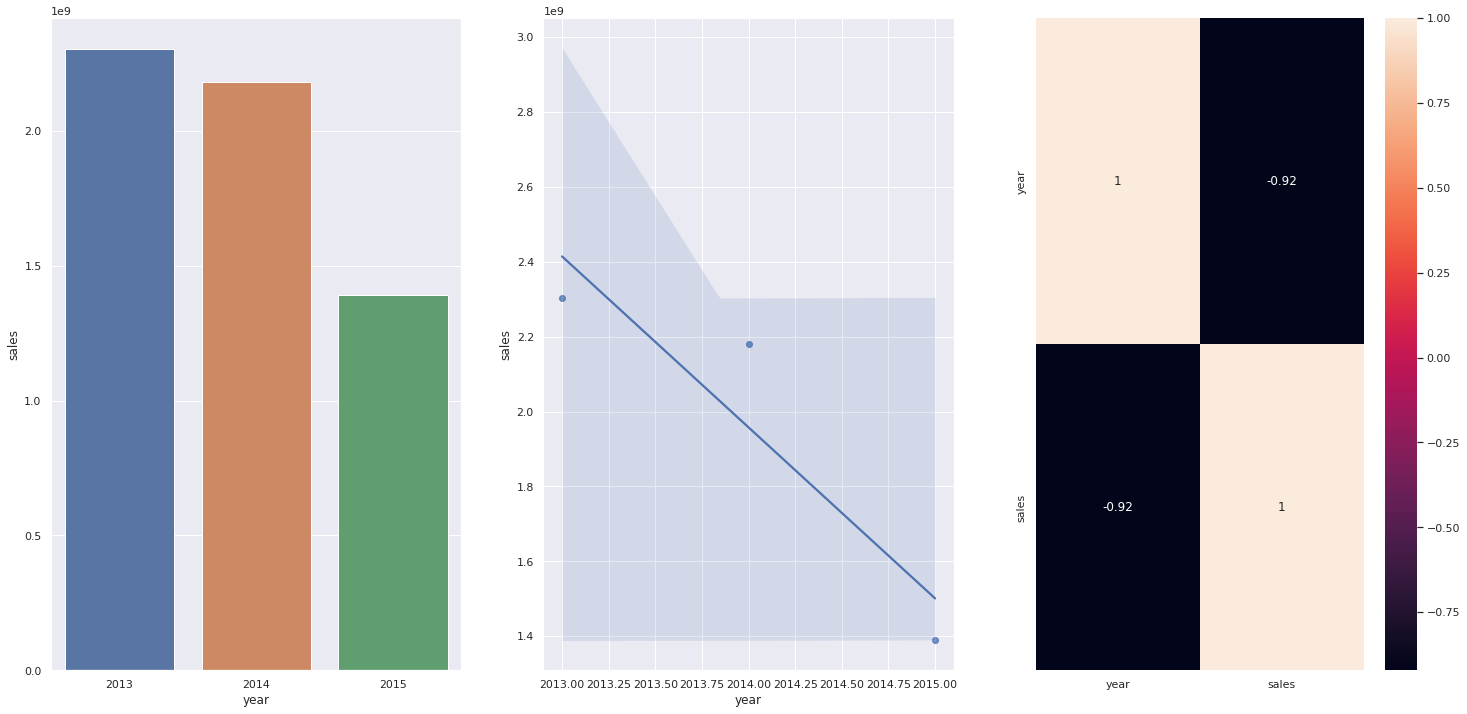

In [38]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year', y= 'sales', data= aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'year', y = 'sales', data= aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method ='pearson'), annot=True);

## H9 - Lojas deveriam vender mais no segundo semestre do ano.

### Falso : Lojas NÃO vendem mais no SEGUNDO semestre do ano.

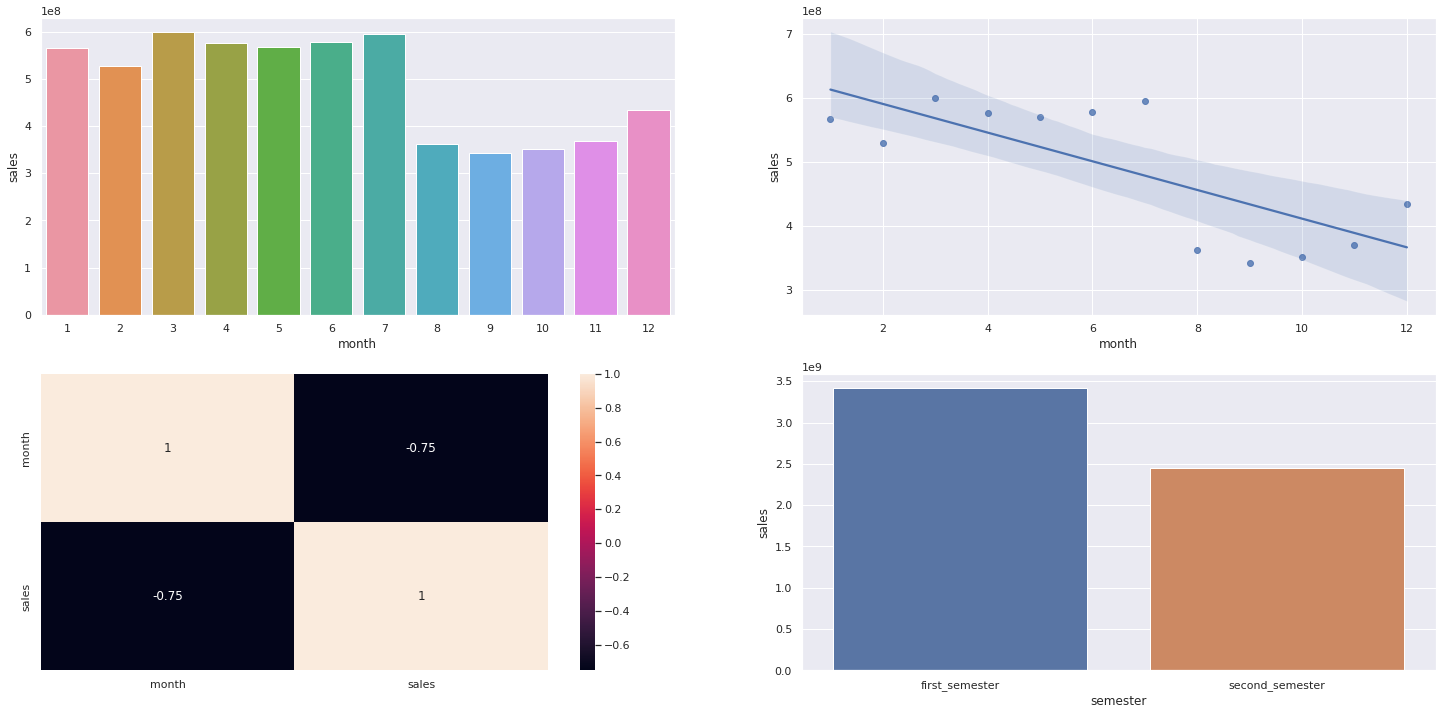

In [39]:
#grouping and ordering the month and sales
aux = df4[['sales', 'month']].groupby('month').sum().reset_index()

#plot the all month
plt.subplot(2,2,1)
sns.barplot(x= 'month', y = 'sales', data = aux);

plt.subplot(2,2,2)
sns.regplot(x= 'month', y = 'sales', data = aux);

plt.subplot(2,2,3)
sns.heatmap(aux.corr(method='pearson'), annot = True);

# ========= split the year in semester  ============= #

aux['semester'] = aux['month'].apply(lambda x: 'first_semester' if x <=6 else 'second_semester')

aux1 = aux[['semester','sales']].groupby('semester').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = 'semester', y = 'sales', data= aux1);


## H8 - Lojas deveriam vender mais depois do dia 10 de cada mês.

# Verdade : Lojas vendem MAIS após o dia 10 de cada mês.

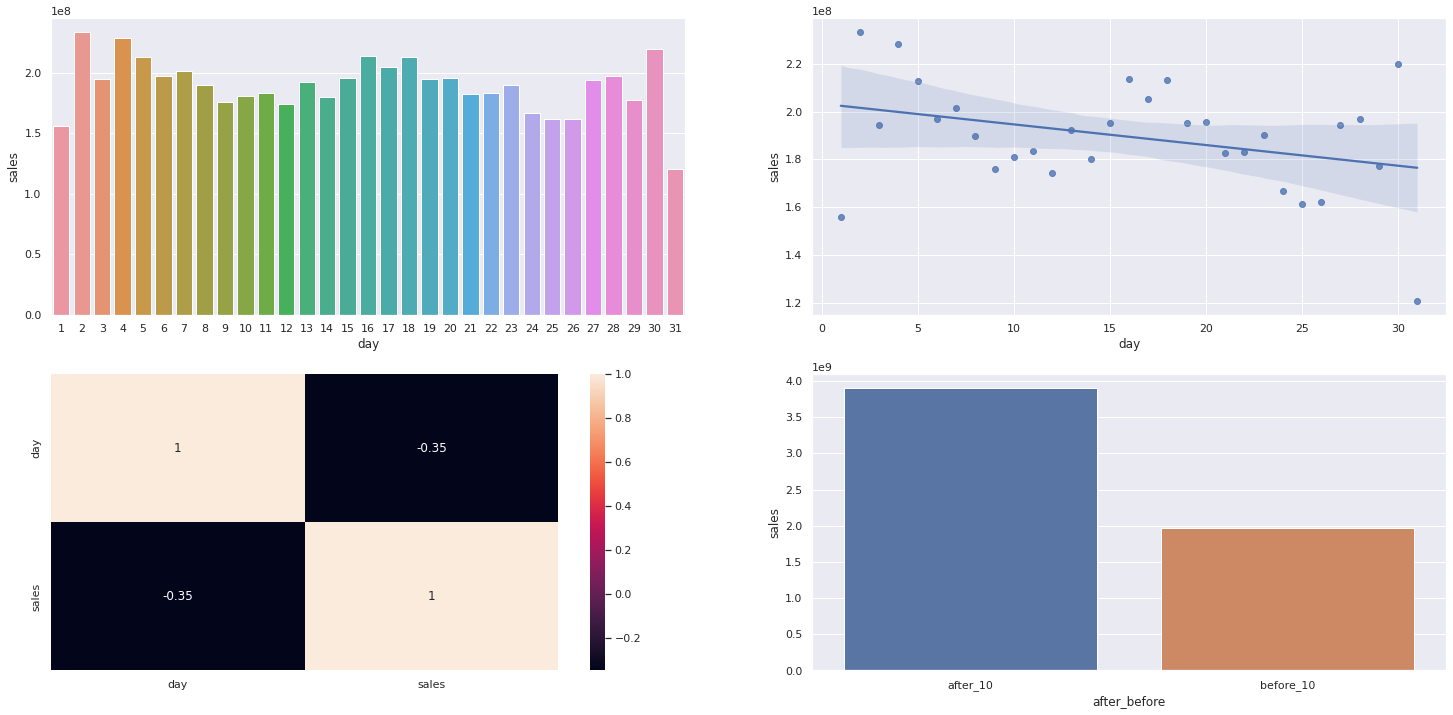

In [40]:
aux = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y = 'sales', data = aux);

plt.subplot(2,2,2)
sns.regplot(x = 'day', y = 'sales', data = aux);

plt.subplot(2,2,3)
sns.heatmap(aux.corr(method = 'pearson'), annot = True);

#================== filtering the data ===============================#

aux['after_before'] = aux['day'].apply(lambda x: 'after_10' if x > 10 else 'before_10')

after_before = aux[['after_before','sales']].groupby('after_before').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = 'after_before', y = 'sales', data= after_before);

## H10 Lojas deveriam vender menos aos finais de semana.

### Verdade: Lojas vendem menos aos finais de semana.

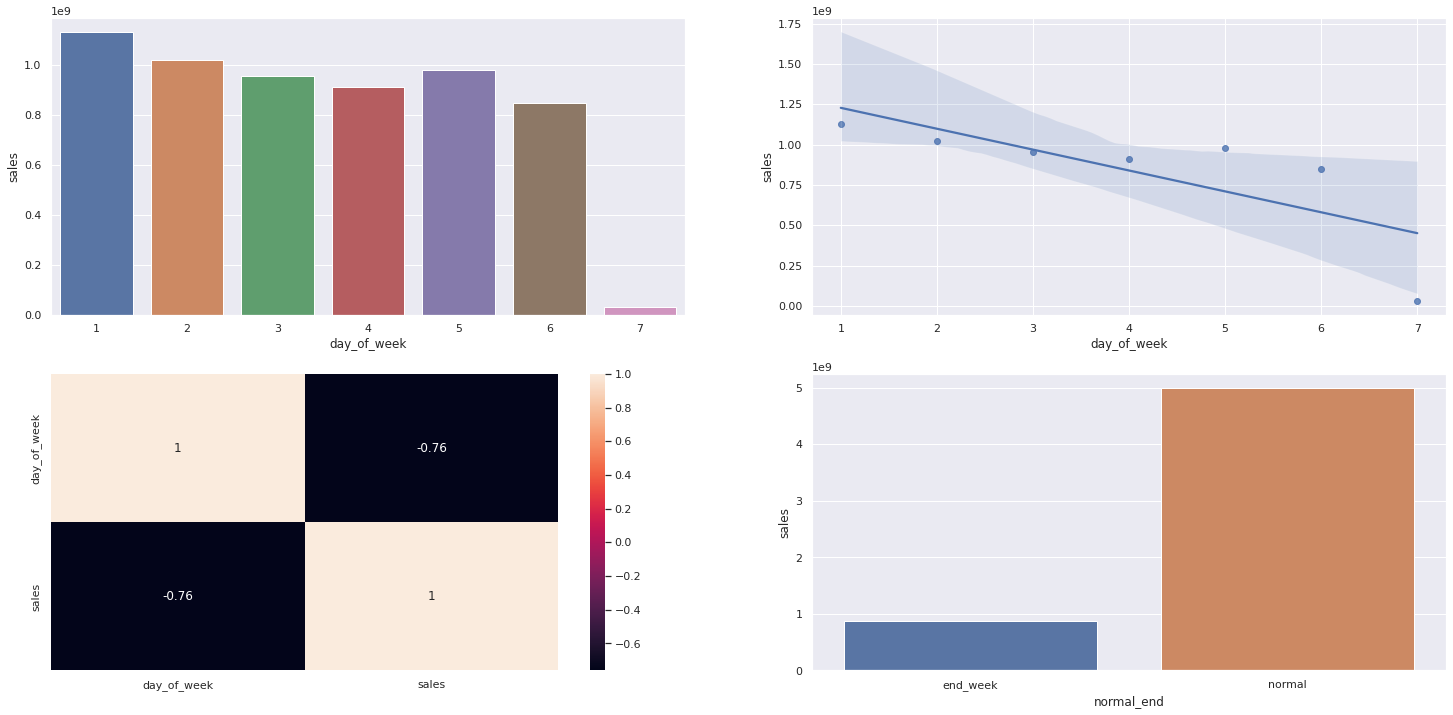

In [41]:
aux = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux);

plt.subplot(2,2,2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux);

plt.subplot(2,2,3)
sns.heatmap(aux.corr(method = 'pearson'), annot = True);

#====================== iltering the days of week ===================
aux['normal_end'] = aux['day_of_week'].apply(lambda x: 'end_week' if x >=6 else 'normal')

days = aux[['normal_end','sales']].groupby('normal_end').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x = 'normal_end', y = 'sales', data = days);

## H11 - Lojas deveriam vender menos durante os feriados escolares.

### Verdade: Lojas vendem menos durante os feriados escolares, exceto Julho e Agosto.

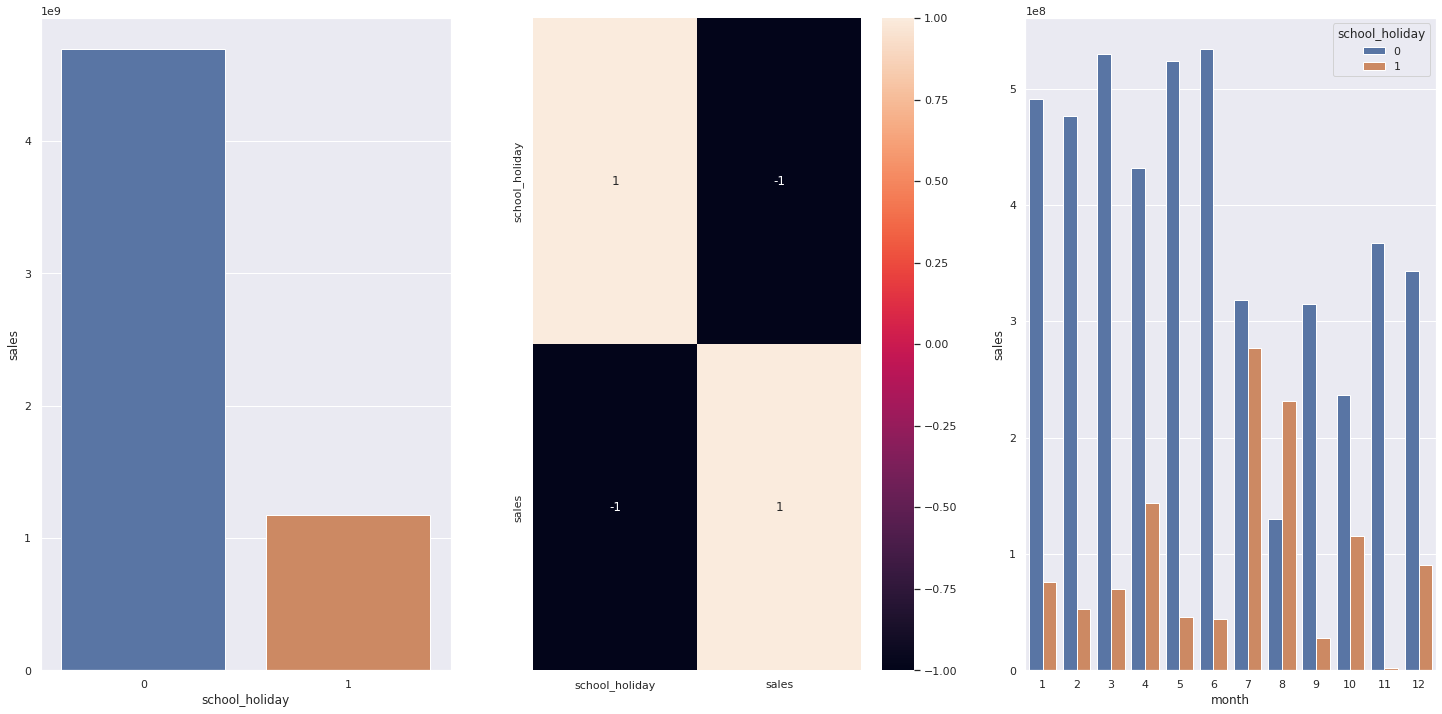

In [42]:
aux = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'school_holiday', y = 'sales', data= aux);

plt.subplot(1,3,2)
sns.heatmap(aux.corr(method = 'pearson'), annot = True);

# ======== Comparative by month =========================================# 

aux1 = df4[['school_holiday','month','sales']].groupby( ['month','school_holiday'] ).sum().reset_index()

plt.subplot(1,3,3)
sns.barplot(x = 'month', y = 'sales', hue='school_holiday', data= aux1);

## 4.2.1 Summary Hypothesis

In [43]:
tab = [ 
['Hypothesis','Conclusion', 'Relevance'], 
['H1', '- -',  '- -'],      
['H2','False','Mean'], 
['H3','False','High'],
['H4','False','Alta'],
['H5','False','High'],
['H6','False','High'], 
['H7','True' , 'Low'],
['H8','False','Mean'],
['H9','False','High'], 
['H10','True','High'], 
['H11','True','High'] ]
      
print(tabulate(tab, headers = 'firstrow'))   
        

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            - -           - -
H2            False         Mean
H3            False         High
H4            False         Alta
H5            False         High
H6            False         High
H7            True          Low
H8            False         Mean
H9            False         High
H10           True          High
H11           True          High


## 4.3 - Analyst Multivariable 

## 4.3.1 Numerical Attributes

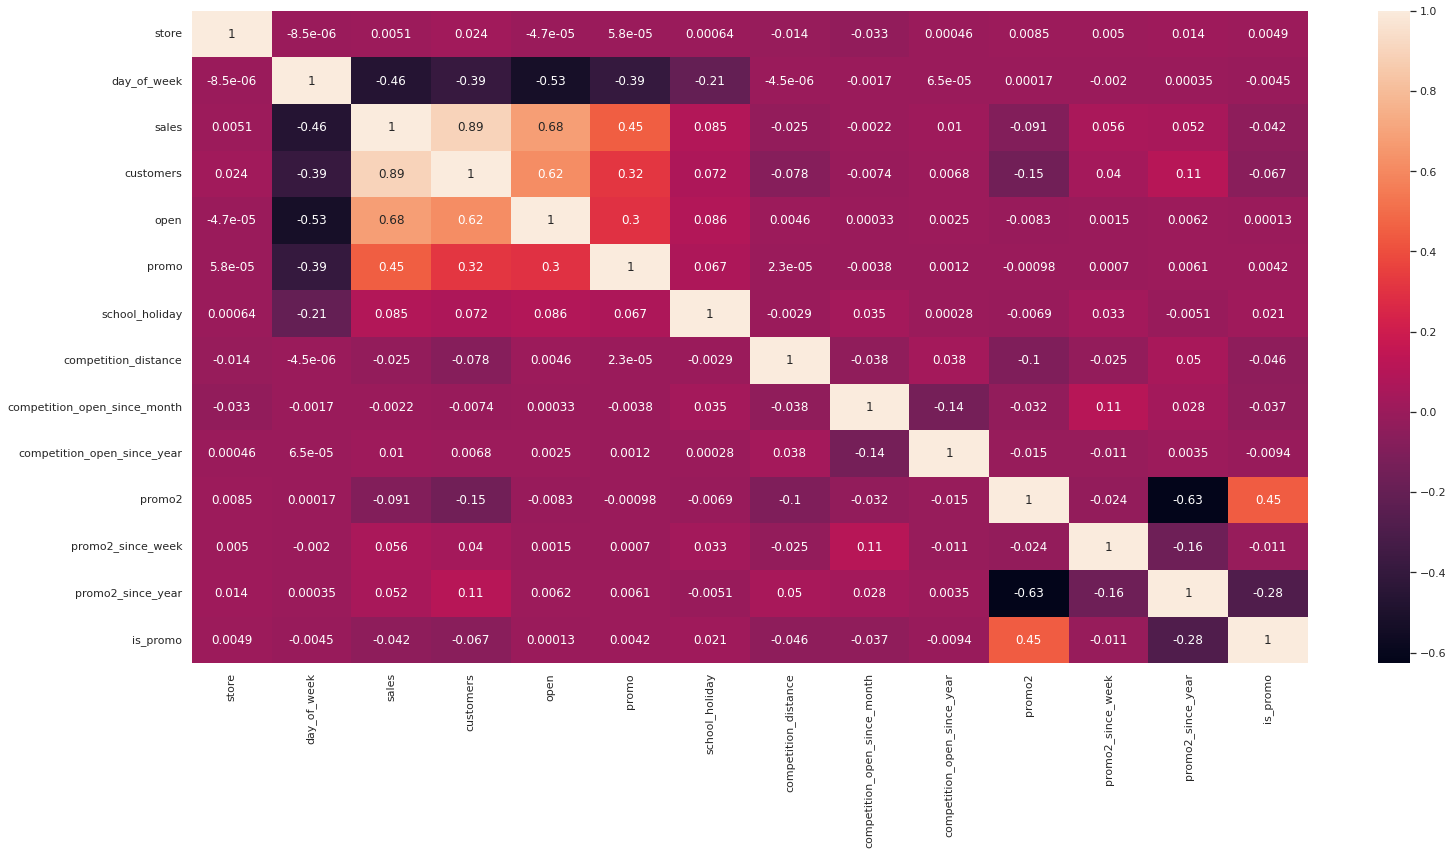

In [44]:
sns.heatmap(num_attributes.corr(method = 'pearson'), annot= True);

## 4.3.2 Categorical Attributes

In [45]:
#only variable of types object 
categorical = df4.select_dtypes( include = ['object'] )

categorical.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [46]:
#making dataframe of correlation with variable the columns of types object
df_categorical =  corr_matrix( categorical, ['state_holiday', 'store_type','assortment'])

df_categorical


,state_holiday,store_type,assortment
state_holiday,1.000000,0.071040,0.067519
store_type,0.071040,1.000000,0.538454
assortment,0.067519,0.538454,1.000000


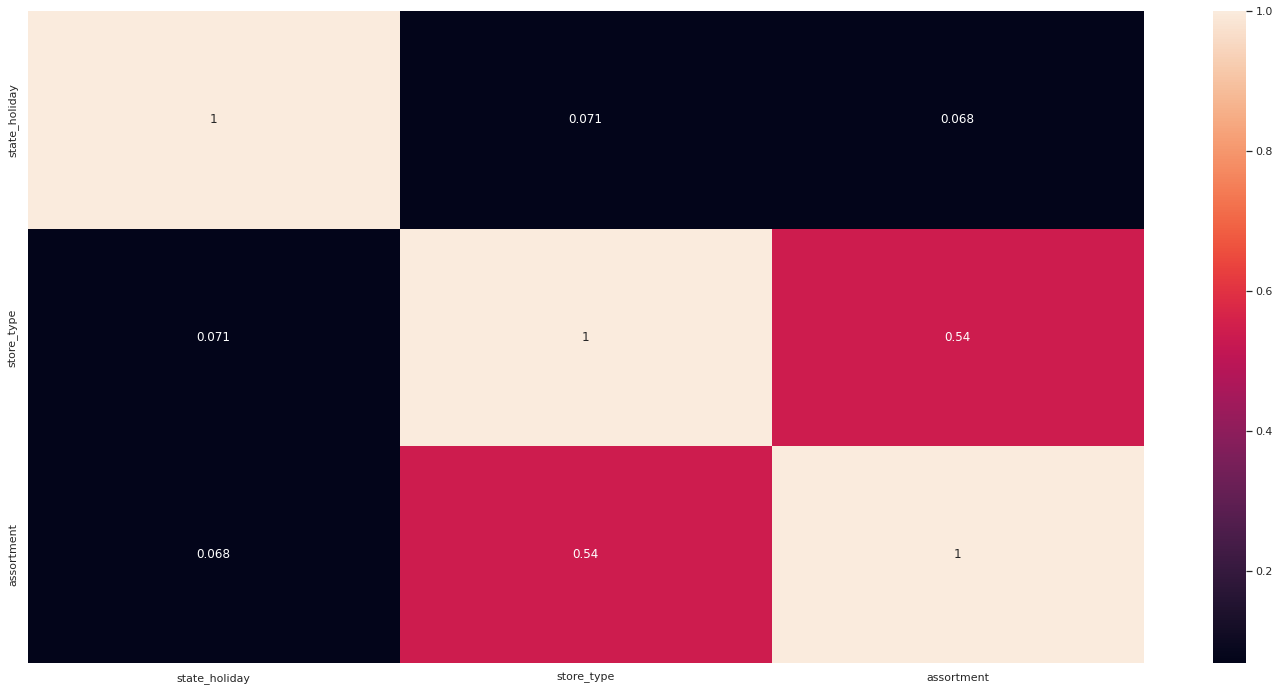

In [47]:
#plot of correlation between variable categoricals
sns.heatmap( df_categorical, annot = True);

# 5 - Data Preparation

In [48]:
df5 = df4.copy(deep=True)

## 5 . 1 Normalization Data

* Olhando o tópico Numerical Variable do item 4 é possível verificar que não há nenhum distribuição normal dos dados 

## 5.2 Rescaling

In [49]:
selection = df5.select_dtypes( include = ['int64', 'float64'] )

m1

,attributes,mean,median,min,max,range,std,skew,kurtosis
0,store,558.429727,558.0,1.0,1115.0,1114.0,321.908493,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.0,7.0,6.0,1.997390,0.001593,-1.246873
2,sales,5773.818972,5744.0,0.0,41551.0,41551.0,3849.924283,0.641460,1.778375
3,customers,633.145946,609.0,0.0,7388.0,7388.0,464.411506,1.598650,7.091773
4,open,0.830107,1.0,0.0,1.0,1.0,0.375539,-1.758045,1.090723
5,promo,0.381515,0.0,0.0,1.0,1.0,0.485758,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.0,1.0,1.0,0.383056,1.677842,0.815154
7,competition_distance,5935.442677,2330.0,20.0,200000.0,199980.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,6.786849,7.0,1.0,12.0,11.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,1900.0,2015.0,115.0,5.515591,-7.235657,124.071304


In [50]:
selection.head(3)

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,compettion_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226


In [51]:
rs = RobustScaler()

mmr = MinMaxScaler()

#competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

#competition_time_month
df5['compettion_time_month'] = rs.fit_transform( df5[['compettion_time_month']].values )

#promo_time_week
df5['promo_time_week'] = mmr.fit_transform( df5[['promo_time_week']].values )

#year
df5['year'] = mmr.fit_transform( df5[['year']].values )


## 5. 3 Transformation

## 5.3.1 - Response Variable Transformation

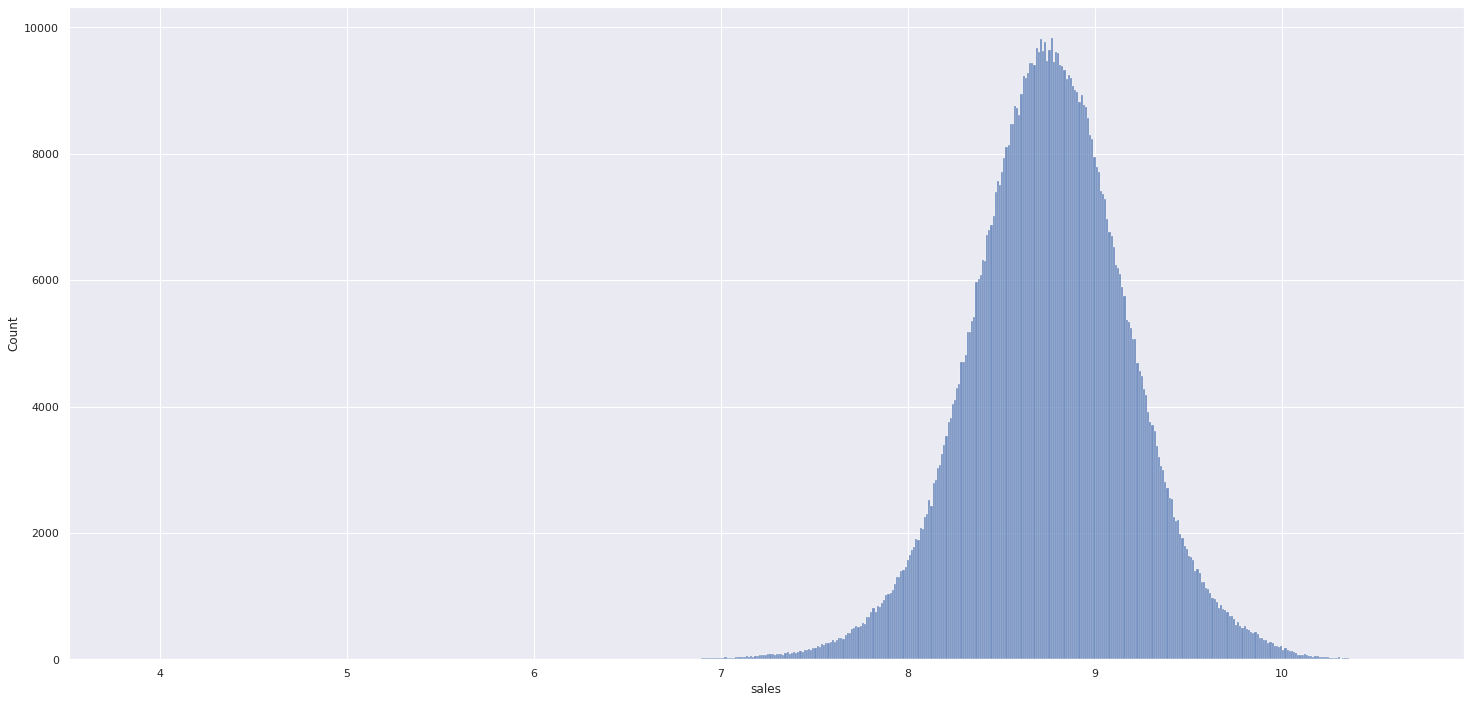

In [52]:
#transformation in a sclae log
df5['sales'] = np.log1p( df5['sales'] )

#plot response variable transformated
sns.histplot( x= 'sales', data = df5 );

## 5.3.2 Enconding

In [53]:
# ======================================= state_holiday ====================================== #

# One Hot Enconding

df5 = pd.get_dummies( df5, prefix= ['st_holiday'], columns = ['state_holiday'] )


# ====================================== store type ============================================ #

# Label Enconding 

le =LabelEncoder()

df5['store_type_encoded'] = le.fit_transform(df5.store_type)

# ===================================== assortment ============================================== #

# Ordinal Encoding

#created dictionary referencial
types_assortment = {'basic': 1,
                   'extended':2,
                   'extra': 3 } 

df5['assortment_ordinal'] = df5.assortment.map(types_assortment)

## 5.3.3 Nature Transformation

In [54]:
# ==================================== day of week ========================================= #

df5['day_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2 * np.pi/ 7 ) ) ) 
df5['day_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2 * np.pi/ 7 ) ) )

# ==================================== month =============================================== #

df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2 * np.pi / 12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2 * np.pi / 12 ) ) )

# ==================================== week of year ========================================= #

df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2 * np.pi/ 53 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2 * np.pi/ 53 ) ) )

NameError: name 'df5' is not defined